# **Question1**

In [ ]:
import scipy.linalg as sl
import numpy as np

In [ ]:
M = [[1, 2],
     [2, 1],
     [3, 4],
     [4, 3]]
M = np.array(M)
U, s, Vh = sl.svd(M, full_matrices=False)
print('U')
print(U)
print('Sigma')
print(s)
print('Vh')
print(Vh)

Evals, Evecs = sl.eigh(M.T @ M)

indices = np.argsort(Evals)

Evals = Evals[indices]
Evecs = Evecs[:, indices]

print('Evals')
print(Evals)
print('Evecs')
print(Evecs)

U
[[-0.27854301  0.5       ]
 [-0.27854301 -0.5       ]
 [-0.64993368  0.5       ]
 [-0.64993368 -0.5       ]]
Sigma
[7.61577311 1.41421356]
Vh
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
Evals
[ 2. 58.]
Evecs
[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]


# **Question 2**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
import itertools
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
#from pyspark.sql.functions import * Nếu chúng ta làm điều này, nó sẽ bao gồm abs
import re, sys, pickle
from functools import reduce
import pyspark.sql.functions as F
import matplotlib.pyplot as pl

In [ ]:
# Tạo the Spark Session
spark = SparkSession.builder.getOrCreate()

# Tạo the Spark Context
sc = spark.sparkContext

In [ ]:
#Euclidian
def l22(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + b * b, delta, 0)
#Manhattan
def l1(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + abs(b), delta, 0)

def findCentroid(pt, cens, distFcn, phi):
    best = float('inf')
    besti = None
    for i, cen in enumerate(cens.value):
        cand = distFcn(pt, cen)
        if cand < best:
            best = cand
            besti = i
    phi += best
    return besti, pt

def aggregate_UV(cumulative, pt):
    cumulative_pt, cumulative_cnt = cumulative
    for i in range(len(pt)):
        cumulative_pt[i] += pt[i]
    return cumulative_pt, cumulative_cnt + 1

def aggregate_UU(a, b):
    a_pt, a_cnt = a
    b_pt, b_cnt = b
    for i in range(len(a_pt)):
        a_pt[i] += b_pt[i]
    return a_pt, a_cnt + b_cnt

In [ ]:
#Chúng ta cần làm từng cái và kết hợp lại mọi thứ (c1 - l1, c1 -l22, c2 - l1 and c2 - l22)
#Tôi giữ nguyên tên của các biến để dễ dàng nhận xét và bỏ ghi chú hơn
dataFile = 'data.txt'
censFile = 'c1.txt' #chúng ta cần bình luận và bỏ ghi chú cái nào chúng ta không muốn sử dụng
censFile = 'c2.txt'
distFcn = l1 #Manhattan
distFcn = l22 #Euclidian
outFile = 'dist_' + l22.__name__ + '__' + censFile
outFile = 'dist_' + l1.__name__ + '__' + censFile

MAX_ITER = 20 #max iterations
k = 10 #clusters
NDATA = 4601
NDIM = 58
cens = []


# init centroids - py way :D
cens = []
with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

# load data
data = sc.textFile( dataFile)
data = data.map(lambda l: list(map(float, l.split())))

phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    # M: calc new centroid
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    # record cost, prep new iter
    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)

     







iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












438747790.027918
249803933.626003
194494814.406313
169804841.451543
156295748.806276
149094208.108966
142508531.619615
132303869.406530
117170969.837191
108547377.178570
102237203.317996
98278015.749757
95630226.121774
93793314.051193
92377131.968211
91541606.254239
91045573.830425
90752240.101408
90470170.181227
90216416.175631









Euclidian c1 0.2648391714456053
Euclidian c2 0.7669795594605946
Manhattan c1 0.2648391714456053
Manhattan c2 0.7669795594605946


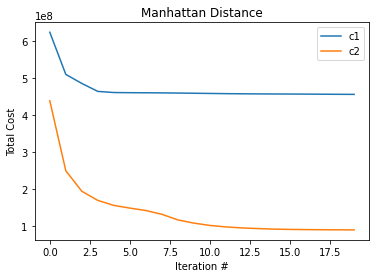

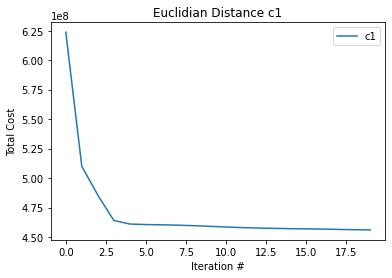

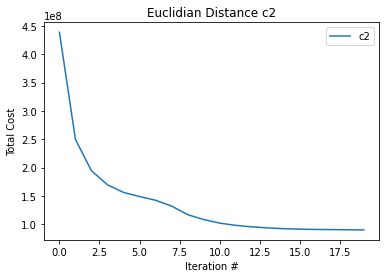

In [ ]:
pl.close('all')

with open('dist_l1__c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('dist_l1__c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('dist_l22__c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('dist_l22__c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)

pl.title("Manhattan Distance")
pl.plot(l1c1, label='c1')
pl.plot(l1c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotManhattan.png', dpi=300, bbox_inches='tight')

pl.figure()
pl.title("Euclidian Distance c1")
pl.plot(l22c1, label='c1')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC1.png', dpi=300, bbox_inches='tight')
pl.figure()
pl.title("Euclidian Distance c2")
pl.plot(l22c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC2.png', dpi=300, bbox_inches='tight')


def change(L):
    return (L[0] - L[10]) / L[0]

print('Euclidian c1', change(l22c1))
print('Euclidian c2', change(l22c2))
print('Manhattan c1', change(l1c1))
print('Manhattan c2', change(l1c2))

# **Question 3**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
k = 20
lamb = 0.1
iters = 40
eta = 0.015

trainfile = "ratings.train.txt"
myfile = open(trainfile, 'r')

q = {}
p = {}

In [ ]:
# Lần lặp đầu tiên, khởi tạo tất cả q và p
for line in myfile:
    items = line.strip().split("\t")
    q_row = int(items[0])
    p_row = int(items[1])
    if q_row in q:
        pass
    else:
        q[q_row] = np.random.rand(k) * np.sqrt(5.0/float(k))
    if p_row in p:
        pass
    else:
        p[p_row] = np.random.rand(k) * np.sqrt(5.0/float(k))


#Bắt đầu huấn luyện dữ liệu
error_record = []
for ii in range(iters):
    #Trong mỗi iter, mở tập tin một lần nữa
    readfile = open(trainfile, 'r')
    for readline in readfile:
        ratings = readline.strip().split("\t")
        q_idx = int(ratings[0])
        p_idx = int(ratings[1])
        rate = int(ratings[2])

        qi = q[q_idx]
        pu = p[p_idx]
        pu_T = pu.reshape(k, 1)
        varep = 2.0 * (rate - np.dot(qi, pu_T))
        # update
        qi_new = qi + eta * (varep * pu - 2.0 * lamb * qi)
        pu_new = pu + eta * (varep * qi - 2.0 * lamb * pu)
        q[q_idx] = qi_new
        p[p_idx] = pu_new
    # tính toán lỗi
    error = 0.0
    readfile = open(trainfile, 'r')
    for readline in readfile:
        ratings = readline.strip().split("\t")
        q_idx = int(ratings[0])
        p_idx = int(ratings[1])
        rate = int(ratings[2])

        qi = q[q_idx]
        pu = p[p_idx]
        pu_T = pu.reshape(k, 1)
        error += (rate - np.dot(qi, pu_T)) ** 2
    for q_key in q:
        error += np.sum(q[q_key] * q[q_key])
    for p_key in p:
        error += np.sum(p[p_key] * p[p_key])
    # ghi lại lỗi trong mỗi iter
    error_scalar = error.reshape(())
    print(str(ii + 1 ) + " of " + str(iters) + " iters: " + str(error_scalar))
    error_record.append(error_scalar)

1 of 40 iters: 93084.64638951526
2 of 40 iters: 91556.29692275493
3 of 40 iters: 90398.78571068688
4 of 40 iters: 88586.68279468821
5 of 40 iters: 86162.37164784872
6 of 40 iters: 83790.29411869653
7 of 40 iters: 81626.26583923928
8 of 40 iters: 79572.4109760485
9 of 40 iters: 77619.76747216361
10 of 40 iters: 75811.94583345299
11 of 40 iters: 74181.5809409448
12 of 40 iters: 72735.40112086727
13 of 40 iters: 71463.17143500091
14 of 40 iters: 70347.83214896057
15 of 40 iters: 69371.16386298514
16 of 40 iters: 68516.0466303551
17 of 40 iters: 67767.04952865987
18 of 40 iters: 67110.43084738943
19 of 40 iters: 66534.01742940512
20 of 40 iters: 66027.09083447329
21 of 40 iters: 65580.28259501336
22 of 40 iters: 65185.46238818821
23 of 40 iters: 64835.614777083356
24 of 40 iters: 64524.71016691759
25 of 40 iters: 64247.578142602964
26 of 40 iters: 63999.78948161856
27 of 40 iters: 63777.550205686835
28 of 40 iters: 63577.608672490234
29 of 40 iters: 63397.17527304801
30 of 40 iters: 63233.

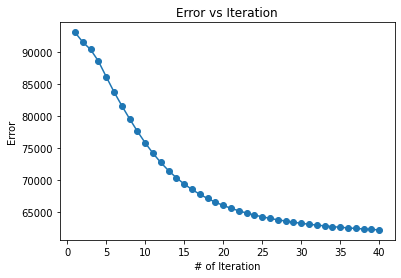

In [ ]:
x = np.arange(0, iters, 1) + 1
y = error_record
plt.plot(x, y, "-o")
plt.xlabel("# of Iteration")
plt.ylabel("Error")
plt.title("Error vs Iteration")
plt.savefig('plot03.png', dpi=300, bbox_inches='tight')
plt.show()

# **Question 4**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
import itertools
import numpy as np

In [ ]:
dataPath = 'user-shows.txt'
showsPath = 'shows.txt'
m = 9985
n = 563
alexi = 499 # user alexy ID
shows = []

In [ ]:
with open(showsPath) as f:
    for line in f:
        shows.append(line.strip())


R = np.zeros((m, n), dtype=np.int16)
with open(dataPath) as f:
    for i, line in enumerate(f):
        R[i, :] = list(map(int, line.split()))

p = np.sum(R, axis=1)
q = np.sum(R, axis=0)

p_ = 1 / np.sqrt(p)
q_ = 1 / np.sqrt(q)

RTp_ = R.T * p_[None, :]
Rq_ = R * q_[None, :]

rU = RTp_.T @ RTp_ @ R
rI = R @ Rq_.T @ Rq_

rU_focus = rU[alexi, :100]
rI_focus = rI[alexi, :100]

#only get top 5 results
rU_idx = np.argsort(rU_focus)[::-1][:5]
rI_idx = np.argsort(rI_focus)[::-1][:5]

rU_results = list(zip(rU_focus[rU_idx], rU_idx, [shows[i] for i in rU_idx]))
rI_results = list(zip(rI_focus[rI_idx], rI_idx, [shows[i] for i in rI_idx]))

print(rU_results)
print(rI_results)

[(908.480053476128, 96, '"FOX 28 News at 10pm"'), (861.1759992873301, 74, '"Family Guy"'), (827.6012954743582, 45, '"2009 NCAA Basketball Tournament"'), (784.7819589039739, 60, '"NBC 4 at Eleven"'), (757.6011181024228, 9, '"Two and a Half Men"')]
[(31.364701678342396, 96, '"FOX 28 News at 10pm"'), (30.001141798877764, 74, '"Family Guy"'), (29.396797773402554, 60, '"NBC 4 at Eleven"'), (29.22700156150048, 45, '"2009 NCAA Basketball Tournament"'), (28.97127767405556, 82, '"Access Hollywood"')]
